# This is a notebook for the implementation of the paper Deep k-Nearest Neighbors: Towards Confident, Interpretable and Robust Deep Learning (https://arxiv.org/abs/1803.04765)

In [1]:
import tensorflow as tf
import os
import numpy as np
import struct
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1 import ImageGrid

For experiment I'll use the MNIST dataset from http://yann.lecun.com/exdb/mnist/. The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. Each image is reperesented in grayscale and has size 28 * 28 pixels. Since we will use a Neural Network for classification we need to normalize the pixel values to the space [0,1]. 

In [2]:
def load_mnist():
    path = os.getcwd()
    # Train data
    fname_train_images = os.path.join(path, 'train-images-idx3-ubyte')  # the training set image file path
    fname_train_labels = os.path.join(path, 'train-labels-idx1-ubyte')  # the training set label file path

    # open the label file and load it to the "train_labels"
    with open(fname_train_labels, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        train_labels = np.fromfile(flbl, dtype=np.uint8)

    # open the image file and load it to the "train_images"
    with open(fname_train_images, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        train_images = np.fromfile(fimg, dtype=np.uint8).reshape(len(train_labels), rows, cols)


    # Test data
    fname_test_images = os.path.join(path, 't10k-images-idx3-ubyte')  # the test set image file path
    fname_test_labels = os.path.join(path, 't10k-labels-idx1-ubyte')  # the test set label file path

    # open the label file and load it to the "test_labels"
    with open(fname_test_labels, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        test_labels = np.fromfile(flbl, dtype=np.uint8)

      # open the image file and load it to the "train_images"
    with open(fname_test_images, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        test_images = np.fromfile(fimg, dtype=np.uint8).reshape(len(test_labels), rows, cols)


    # Preprocessing
    # Covert y into a column vector
    train_images_flatten = train_images.reshape(train_images.shape[0], -1)
    test_images_flatten = test_images.reshape(test_images.shape[0], -1)

    train_set_x = train_images_flatten/255.
    test_set_x = test_images_flatten/255.

    # Convert labels to one-hot
    train_labels_oh=np.empty([len(train_labels), 10])
    test_labels_oh=np.empty([len(test_labels), 10])

    temp_eye=np.eye(10)
    for i in range(len(train_labels)):
        train_labels_oh[i]=temp_eye[train_labels[i]]
    for i in range(len(test_labels)):
        test_labels_oh[i]=temp_eye[test_labels[i]]
        
    return train_set_x,train_labels,train_labels_oh,test_set_x,test_labels,test_labels_oh

I created the LSH function to convert a vector of features to a hash code.

In [3]:
def LSH(x,y1,y2,y3,planes1,planes2,planes3,planes4):
    k=np.matmul(x,planes1)
    k[k>0]=1
    k[k<0]=-1
    k1=np.matmul(y1,planes2)
    k1[k1>0]=1
    k1[k1<0]=-1
    k2=np.matmul(y2,planes3)
    k2[k2>0]=1
    k2[k2<0]=-1
    k3=np.matmul(y3,planes4)
    k3[k3>0]=1
    k3[k3<0]=-1
    return k,k1,k2,k3

We load the training and test images as row vectors. So each image is represented by a row vector of 784 features (28 * 28). We also load the labels of the dataset oth as absolute values between 0 and 9 and as one-hot vector e.g.

|Label|One-hot vector|
|-----|--------------|
|  0  |1000000000    |
|  1  |0100000000    |
|  2  |0010000000    |
|  3  |0001000000    |
|  4  |0000100000    |
|  5  |0000010000    |
|  6  |0000001000    |
|  7  |0000000100    |
|  8  |0000000010    |
|  9  |0000000001    |

In [4]:
#Read the input data
train_set_x,train_labels,train_labels_oh,test_set_x,test_labels,test_labels_oh=load_mnist()

## Some examples of MNIST images

These are some informations regarding the training set shape we have loaded
Training image shape (60000, 784)
Training labels shape (60000, 10)

 The following are some of the training images from the MNIST dataset


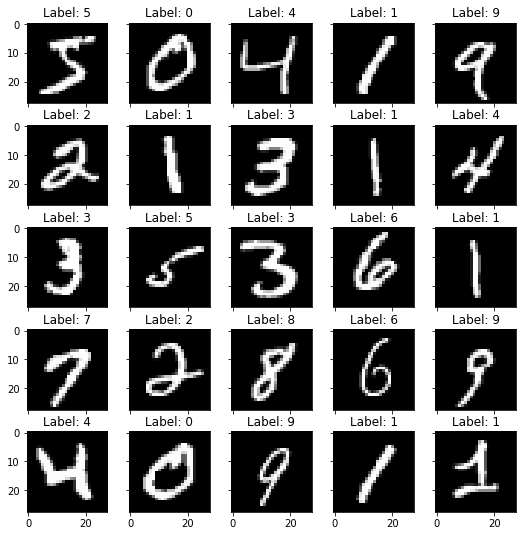

In [5]:
print('These are some informations regarding the training set shape we have loaded')
print("Training image shape",train_set_x.shape)
print("Training labels shape", train_labels_oh.shape)

print('\n The following are some of the training images from the MNIST dataset')

# Review a few images
image_list = train_set_x[0:25]
image_list_labels = train_labels_oh[0:25]

# https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#imagegrid
fig = plt.figure(1, (9., 9.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 5x5 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for i in range(len(image_list)):
    image = image_list[i].reshape(28,28)
    grid[i].imshow(image, cmap='gray')
    grid[i].set_title('Label: {0}'.format(image_list_labels[i].argmax()))

plt.show()

## The hyperparameters

In [6]:
image_size  = 28
labels_size = 10
learning_rate = 0.5
epochs = 800
batch_size = 512
hidden_layers=3
h1_size=200
h2_size=100
h3_size=20
h4_size=10
planes_input_num=250
planes_l1_num=80
planes_l2_num=50
planes_l3_num=10
k_neighbors=75
calibration_size=8000

## The Feedforward Neural Network
For the classification of the MNIST images I train a feedforward neural network with input of size 784, 3 hidden layers and output of 10 classes. All the weights are initialized using the Xavier Initializer. The activation function used in the hidden layers is the ReLU function. During training we use the cross entropy loss function and the Gredient Descent Optimizer to minimize the loss function.

In [7]:
# Create the model
# Placeholder is a value that we input when we ask TensorFlow to run a computation.
x = tf.placeholder(tf.float32, [None, 784])
W1 = tf.get_variable("W1", shape=[784,h1_size], initializer=tf.contrib.layers.xavier_initializer())
b1=tf.Variable(tf.zeros([h1_size]))
y1=tf.nn.relu(tf.matmul(x, W1)+b1)
W2 = tf.get_variable("W2", shape=[h1_size,h2_size], initializer=tf.contrib.layers.xavier_initializer())
b2=tf.Variable(tf.zeros([h2_size]))
y2=tf.nn.relu(tf.matmul(y1,W2)+b2)
W3 = tf.get_variable("W3", shape=[h2_size,h3_size], initializer=tf.contrib.layers.xavier_initializer())
b3=tf.Variable(tf.zeros([h3_size]))
y3 = tf.matmul(y2, W3) + b3
W4 = tf.get_variable("W4", shape=[h3_size,h4_size], initializer=tf.contrib.layers.xavier_initializer())
b4=tf.Variable(tf.zeros([h4_size]))
y = tf.matmul(y3, W4) + b4

y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

img_gradient = tf.gradients(cross_entropy, x)[0]

#Create a tensorflow dataset for the training
dx_train = tf.data.Dataset.from_tensor_slices(train_set_x)
dy_train = tf.data.Dataset.from_tensor_slices(train_labels).map(lambda z: tf.one_hot(z, 10))
train_dataset = tf.data.Dataset.zip((dx_train, dy_train)).shuffle(500).repeat().batch(batch_size)
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
next_element = iterator.get_next()
training_init_op = iterator.make_initializer(train_dataset)

In [8]:
sess  =  tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(training_init_op)

## Training
We evaluate the trained neural network using the 10,000 test images

Accuracy: 0.9698


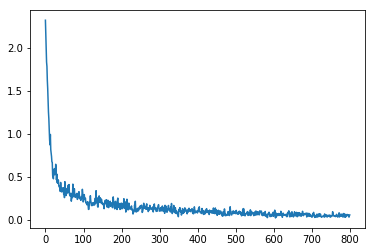

In [9]:
costs=np.zeros(epochs)
for i in range(epochs):
    batch_xs,batch_ys=sess.run(next_element)
    _,loss=sess.run([train_step,cross_entropy], feed_dict={x: batch_xs, y_: batch_ys})
    costs[i]=loss
    #print("Epoch:",i,"Loss=",loss)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:',sess.run(
  accuracy, feed_dict={
      x: test_set_x,
      y_: test_labels_oh
  }))

plt.plot(range(epochs),costs)
plt.show()

## k-Nearest Neighbors and Hashing

Our goal is to have a metric of the confidence for the test data. Many times the probabilities computed by softmax on the output layer are used as a metric of confidence but this approach usually overestimates the confidence when inputs fall outside the training distribution. The presented approach gives a more accurate estimation of the confidence of each prediction.

More specifically we create nearest neighbors classifiers in the space defined by each DNN layer. Because
the output of layers is often high-dimensional we encode the output of each layer to lower dimensions using the Locality Sensitive Hash.
![LSH_scheme](LSH.png)

In the image above we define a number of random planes (lines). Depending on whether the data point locates above or below a gray line, we mark this relation as 0/1. On the upper-left corner, there are two rows of white/black squares, representing the signature of the two data points respectively. Each square is corresponding to a bit 0(white) or 1(black). So once we have a pool of planes, we can encode the data points with their location respective to the planes. More planes will give better estimation of the point's coordinates.

It's simpler and computational efficient, instead of choosing planes from all possible vectors, to choose planes with components +1 and -1 only. The relative position of a point x to a plane u is given by their dot product. Since u has components only +1s and -1s we calculate the dot product by adding the components of x where u is +1 and then subtracting the other components of x. So when we have a data point in n dimensions and m planes $u_1, u_2, ... , u_m$ the encoding of the point with respect to the planes will be given by $
\begin{equation}
\underset{1\times m}{\mathrm{X'}} =  \underset{1\times n}{X} \times 
\underset{n\times m}{U}
\end{equation}
$
and replacing the positive components with +1 and the negative one with -1 as we only care only if the point is above or below each plane.

There are different ways to calculate the distance between encoded points like Euclidean, Jaccard, Cosine and Hamming. Here I use Hamming distance which is defined between two vectors to be the number of components in which they differ.

Many applications have tens of thousands of neurons in each layer producing very high dimensional data points. Representing a data point to lower dimension has effectively reduced the complexity of the calculations to calculate the distance between points by adding some error to the estimated distances speeding up the Nearest Neighbors classifier. 

First we encode the train data meaning input and activation of each layer.

In [10]:
planes1=np.random.choice([1,-1], (784,planes_input_num))
planes2=np.random.choice([1,-1], (h1_size,planes_l1_num))
planes3=np.random.choice([1,-1], (h2_size,planes_l2_num))
planes4=np.random.choice([1,-1], (h3_size,planes_l3_num))

hd1,hd2,hd3=sess.run([y1,y2,y3], feed_dict={x: train_set_x})
input_hash_train,l1_hash_train,l2_hash_train,l3_hash_train=LSH(train_set_x,hd1,hd2,hd3,planes1,planes2,planes3,planes4)

In [11]:
input_nbrs=NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto', metric='hamming').fit(input_hash_train)
l1_nbrs=NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto', metric='hamming').fit(l1_hash_train)
l2_nbrs=NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto', metric='hamming').fit(l2_hash_train)
l3_nbrs=NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto', metric='hamming').fit(l3_hash_train)

Then we encode a number of calibration data (different than the training data) and for each layer of each calibration data we find the closest neighbors to it from the training data.

In [12]:
hd1,hd2,hd3=sess.run([y1,y2,y3], feed_dict={x: test_set_x[:calibration_size]})
input_hash_calibration,l1_hash_calibration,l2_hash_calibration,l3_hash_calibration=LSH(test_set_x[:calibration_size],hd1,hd2,hd3,planes1,planes2,planes3,planes4)

dist, indices_input_calibration = input_nbrs.kneighbors(input_hash_calibration)
dist, indices_l1_calibration = l1_nbrs.kneighbors(l1_hash_calibration)
dist, indices_l2_calibration = l2_nbrs.kneighbors(l2_hash_calibration)
dist, indices_l3_calibration = l3_nbrs.kneighbors(l3_hash_calibration)


## Nonconformity measure

Nonconformity measures assess the degree to which the new example disagrees with the attribute-label relationship of the old examples, according to the underlying algorithm of the Conformal Prediction which in our case case is the Nearest Neighbors classifier. So for each data point from the calibradtion set we find a number of labeled nearest neighbors. We define the nonconformity of an input x with the label j as:
$$\alpha(x,j)=\sum_{\lambda \in 1 .. l} \left|i \in \Omega_\lambda : i\neq j\right|$$
where <br>
$l$ is the number of layers<br>$\Omega_\lambda$ is the set that includes the nearest neighbors for the layer $\lambda$

I calculate and save the nonconformity of each of the calibration data and its corresponding label.

[20 54  1 ...  2 19 89]
The average non comformity of the calibration data in all the layers is 51.0525
Actual label is 7


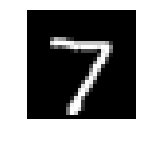

Closest neighbors for the input image


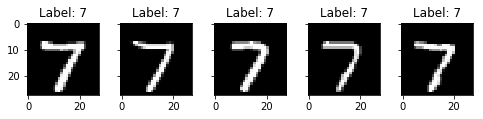

Closest neighbors to layer 1


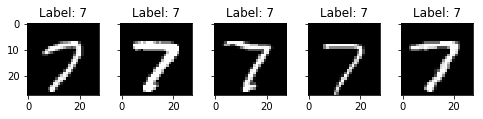

Closest neighbors to layer 2


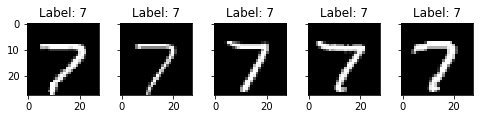

Closest neighbors to layer 3


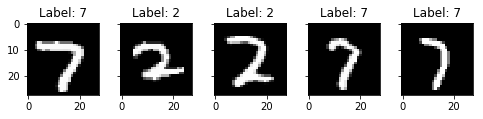

Actual label is 2


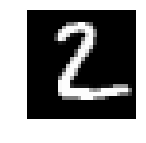

Closest neighbors for the input image


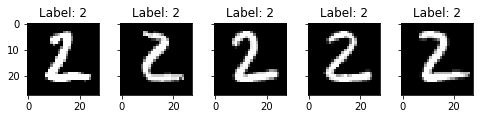

Closest neighbors to layer 1


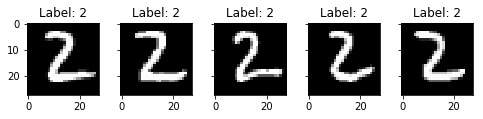

Closest neighbors to layer 2


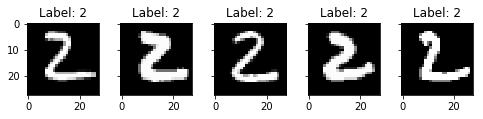

Closest neighbors to layer 3


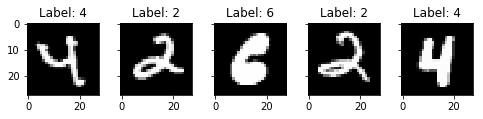

Actual label is 1


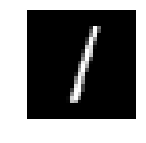

Closest neighbors for the input image


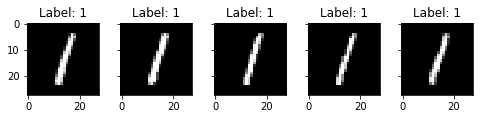

Closest neighbors to layer 1


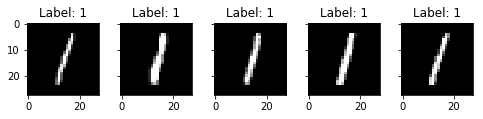

Closest neighbors to layer 2


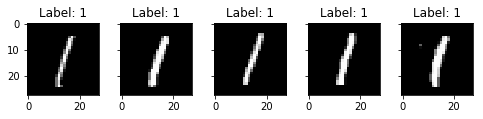

Closest neighbors to layer 3


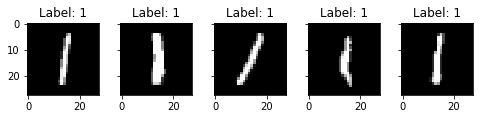

Actual label is 0


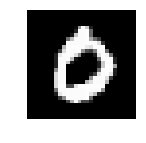

Closest neighbors for the input image


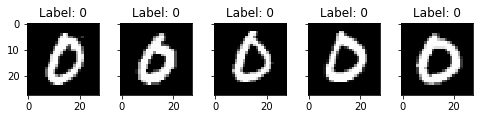

Closest neighbors to layer 1


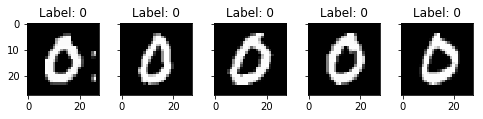

Closest neighbors to layer 2


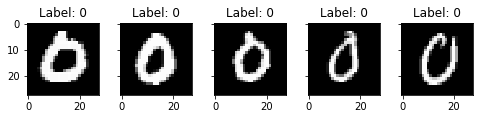

Closest neighbors to layer 3


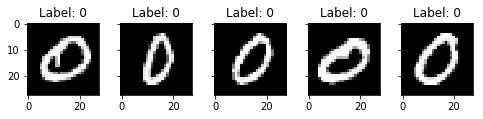

Actual label is 4


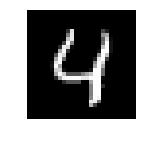

Closest neighbors for the input image


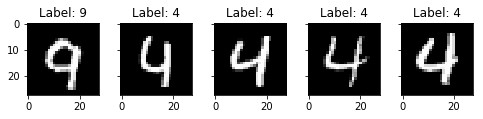

Closest neighbors to layer 1


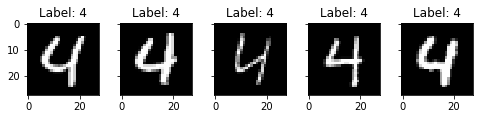

Closest neighbors to layer 2


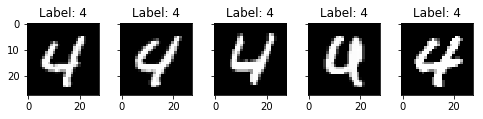

Closest neighbors to layer 3


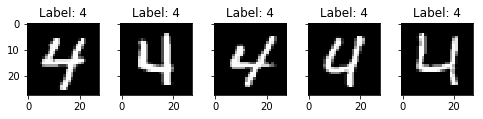

In [13]:
actual_labels=np.array([test_labels[:calibration_size],]*k_neighbors).T
indices_labels_input_calibration=train_labels[indices_input_calibration]
indices_labels_l1_calibration=train_labels[indices_l1_calibration]
indices_labels_l2_calibration=train_labels[indices_l2_calibration]
indices_labels_l3_calibration=train_labels[indices_l3_calibration]

#print('Neighbors of the first 10 calibration data for input and 3 hidden layers')
#print('Input layer')
#print(indices_labels_input_calibration[:10],'\n')
#print('Hidden layer 1')
#print(indices_labels_l1_calibration[:10],'\n')
#print('Hidden layer 2')
#print(indices_labels_l2_calibration[:10],'\n')
#print('Hidden layer 3')
#print(indices_labels_l3_calibration[:10],'\n')


input_calibration_errors=np.count_nonzero(actual_labels!=indices_labels_input_calibration,axis=1)
l1_calibration_errors=np.count_nonzero(actual_labels!=indices_labels_l1_calibration,axis=1)
l2_calibration_errors=np.count_nonzero(actual_labels!=indices_labels_l2_calibration,axis=1)
l3_calibration_errors=np.count_nonzero(actual_labels!=indices_labels_l3_calibration,axis=1)

calibration_noncomformity=input_calibration_errors+l1_calibration_errors+l2_calibration_errors+l3_calibration_errors
print(calibration_noncomformity)
print('The average non comformity of the calibration data in all the layers is',np.mean(calibration_noncomformity))

for i in range(5):
    print('Actual label is', test_labels[i])
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(test_set_x[i].reshape([28, 28]),cmap = "gray")
    plt.show()
    print('Closest neighbors for the input image')
    fig = plt.figure(i, (8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),
                 axes_pad=0.3,  # pad between axes in inch.
                 )
    for j in range(5):
        grid[j].imshow(train_set_x[indices_input_calibration[i,j]].reshape(28,28), cmap='gray')
        grid[j].set_title('Label: {0}'.format(train_labels_oh[indices_input_calibration[i,j]].argmax()))
    plt.show()
    
    print('Closest neighbors to layer 1')
    fig = plt.figure(i, (8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),
                 axes_pad=0.3,  # pad between axes in inch.
                 )
    for j in range(5):
        grid[j].imshow(train_set_x[indices_l1_calibration[i,j]].reshape(28,28), cmap='gray')
        grid[j].set_title('Label: {0}'.format(train_labels_oh[indices_l1_calibration[i,j]].argmax()))
    plt.show()
    
    print('Closest neighbors to layer 2')
    fig = plt.figure(i, (8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),
                 axes_pad=0.3,  # pad between axes in inch.
                 )
    for j in range(5):
        grid[j].imshow(train_set_x[indices_l2_calibration[i,j]].reshape(28,28), cmap='gray')
        grid[j].set_title('Label: {0}'.format(train_labels_oh[indices_l2_calibration[i,j]].argmax()))
    plt.show()
    
    print('Closest neighbors to layer 3')
    fig = plt.figure(i, (8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),
                 axes_pad=0.3,  # pad between axes in inch.
                 )
    for j in range(5):
        grid[j].imshow(train_set_x[indices_l3_calibration[i,j]].reshape(28,28), cmap='gray')
        grid[j].set_title('Label: {0}'.format(train_labels_oh[indices_l3_calibration[i,j]].argmax()))
    plt.show()
    


Out of curiosity I plot the input calibration images that produced the largest nonconformity. As we see these are digits not well written that could be mistaken classified even by a human. 


 The 5 inputs with the most incorrect neighbors
Actual label is 9


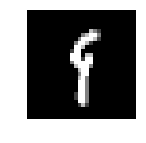

Closest neighbors for the input image


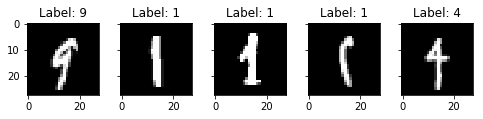

Closest neighbors to layer 1


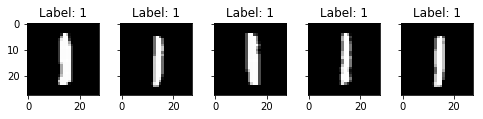

Closest neighbors to layer 2


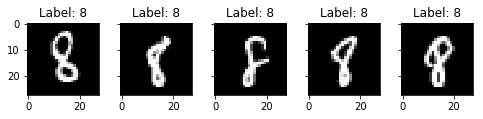

Closest neighbors to layer 3


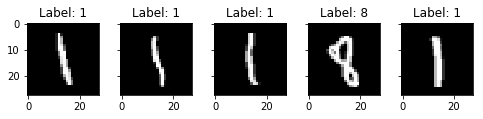

Actual label is 7


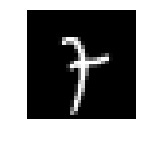

Closest neighbors for the input image


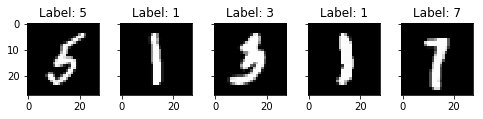

Closest neighbors to layer 1


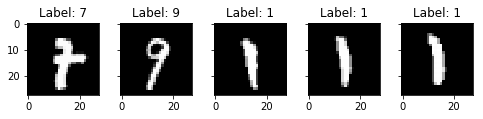

Closest neighbors to layer 2


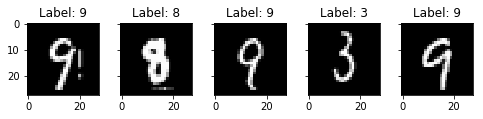

Closest neighbors to layer 3


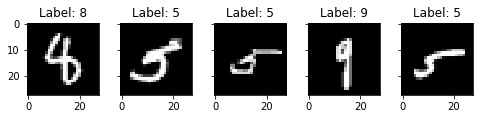

Actual label is 7


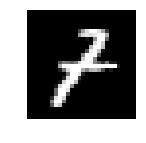

Closest neighbors for the input image


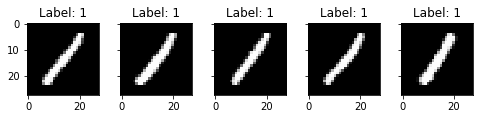

Closest neighbors to layer 1


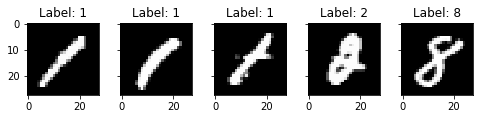

Closest neighbors to layer 2


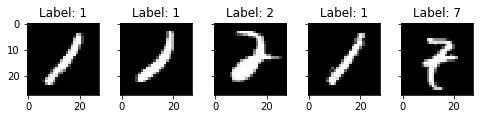

Closest neighbors to layer 3


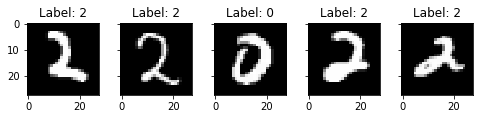

Actual label is 6


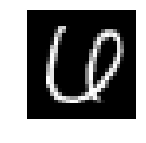

Closest neighbors for the input image


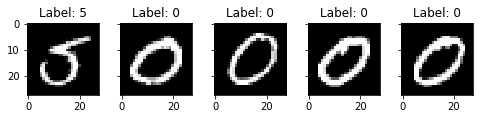

Closest neighbors to layer 1


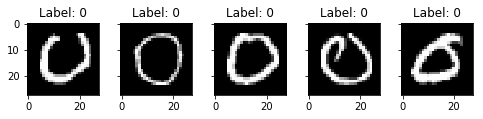

Closest neighbors to layer 2


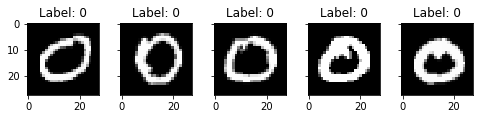

Closest neighbors to layer 3


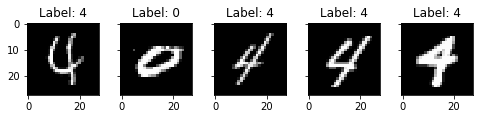

Actual label is 6


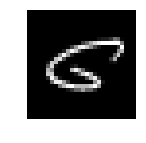

Closest neighbors for the input image


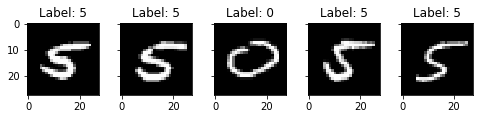

Closest neighbors to layer 1


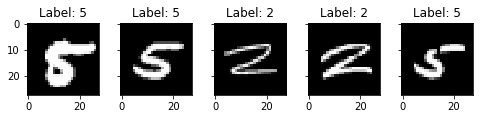

Closest neighbors to layer 2


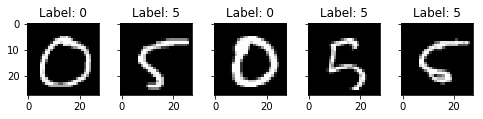

Closest neighbors to layer 3


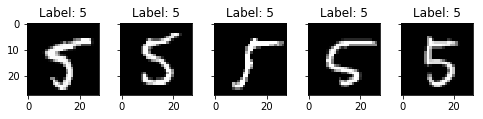

In [14]:
ind = np.argpartition(calibration_noncomformity, -5)[-5:]
print('\n The 5 inputs with the most incorrect neighbors')

for i in range(5):
    print('Actual label is', test_labels[ind[i]])
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(test_set_x[ind[i]].reshape([28, 28]),cmap = "gray")
    plt.show()
    print('Closest neighbors for the input image')
    fig = plt.figure(i, (8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),
                 axes_pad=0.3,  # pad between axes in inch.
                 )
    for j in range(5):
        grid[j].imshow(train_set_x[indices_input_calibration[ind[i],j]].reshape(28,28), cmap='gray')
        grid[j].set_title('Label: {0}'.format(train_labels_oh[indices_input_calibration[ind[i],j]].argmax()))
    plt.show()
    
    print('Closest neighbors to layer 1')
    fig = plt.figure(i, (8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),
                 axes_pad=0.3,  # pad between axes in inch.
                 )
    for j in range(5):
        grid[j].imshow(train_set_x[indices_l1_calibration[ind[i],j]].reshape(28,28), cmap='gray')
        grid[j].set_title('Label: {0}'.format(train_labels_oh[indices_l1_calibration[ind[i],j]].argmax()))
    plt.show()
    
    print('Closest neighbors to layer 2')
    fig = plt.figure(i, (8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),
                 axes_pad=0.3,  # pad between axes in inch.
                 )
    for j in range(5):
        grid[j].imshow(train_set_x[indices_l2_calibration[ind[i],j]].reshape(28,28), cmap='gray')
        grid[j].set_title('Label: {0}'.format(train_labels_oh[indices_l2_calibration[ind[i],j]].argmax()))
    plt.show()
    
    print('Closest neighbors to layer 3')
    fig = plt.figure(i, (8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),
                 axes_pad=0.3,  # pad between axes in inch.
                 )
    for j in range(5):
        grid[j].imshow(train_set_x[indices_l3_calibration[ind[i],j]].reshape(28,28), cmap='gray')
        grid[j].set_title('Label: {0}'.format(train_labels_oh[indices_l3_calibration[ind[i],j]].argmax()))
    plt.show()
    
#print(indices_labels_input_calibration[ind],'\n')
#print(indices_labels_l1_calibration[ind],'\n')
#print(indices_labels_l2_calibration[ind],'\n')
#print(indices_labels_l3_calibration[ind],'\n')

We feed the test data to the NN and store the activations of each layer. We encode them using the same planes as previously and find the nearest neighbots from the training set.

In [15]:
hd1,hd2,hd3=sess.run([y1,y2,y3], feed_dict={x: test_set_x[calibration_size:]})
input_hash_calibration,l1_hash_calibration,l2_hash_calibration,l3_hash_calibration=LSH(test_set_x[calibration_size:],hd1,hd2,hd3,planes1,planes2,planes3,planes4)

dist, indices_input_calibration = input_nbrs.kneighbors(input_hash_calibration)
dist, indices_l1_calibration = l1_nbrs.kneighbors(l1_hash_calibration)
dist, indices_l2_calibration = l2_nbrs.kneighbors(l2_hash_calibration)
dist, indices_l3_calibration = l3_nbrs.kneighbors(l3_hash_calibration)

In [16]:
actual_labels=np.array([test_labels[calibration_size:],]*k_neighbors).T
indices_labels_input_test=train_labels[indices_input_calibration]
indices_labels_l1_test=train_labels[indices_l1_calibration]
indices_labels_l2_test=train_labels[indices_l2_calibration]
indices_labels_l3_test=train_labels[indices_l3_calibration]

input_test_errors=np.count_nonzero(actual_labels!=indices_labels_input_test,axis=1)
l1_test_errors=np.count_nonzero(actual_labels!=indices_labels_l1_test,axis=1)
l2_test_errors=np.count_nonzero(actual_labels!=indices_labels_l2_test,axis=1)
l3_test_errors=np.count_nonzero(actual_labels!=indices_labels_l3_test,axis=1)

test_noncomformity=input_test_errors+l1_test_errors+l2_test_errors+l3_test_errors

#print(test_noncomformity)
print('The average non comformity of the test data in all the layers is',np.mean(test_noncomformity))



The average non comformity of the test data in all the layers is 41.8835


Calculating the nearest neighbors for all the layers of the test data we end up with a number of different candidate labels. 

For each candidate label $j$ of a test data $x$ we compute the nonconformity $\alpha(x,j)$. Then we calculate the fraction of nonconformity measures for the calibration data that are larger than the test input's. This is the empirical p-value of candidate label $j$:
$$p_j(x)=\frac{\left|\{\alpha\in A : \alpha\geq\alpha(x,j)\}\right|}{\left|A\right|}$$
where A are the nonconformity values computed on the set of calibration data.

The <u>predicted label</u> for the test input is the one assigned the largest empirical p-value.<br>
We define the <u>confidence</u> of this prediction as 1 minus the second largest empirical p-value. <br>
Finally, the prediction's <u>credibility</u> is the empirical p-value of the prediction.

In [17]:
candidate_labels=np.concatenate((np.concatenate((np.concatenate((indices_labels_input_test,indices_labels_l1_test),axis=1),indices_labels_l2_test),axis=1),indices_labels_l2_test),axis=1)

test_data_predictions=np.empty([2000,10])
test_data_credibility=np.empty([2000,2]) #confidence, credibility
test_data_predictions_knn=np.empty(2000)
test_data_predictions_softmax=sess.run(tf.nn.softmax(y),feed_dict={x: test_set_x[calibration_size:]})
test_data_correct=(np.argmax(test_data_predictions, 1)==test_labels[calibration_size:])    


print_count=5

print("Nonconformity metrics calculation for the test data")
print("Following are the analytical results for the first 5 test data")
for i in range(2000):
    max_temp=-1
    max_ind=100
    second_max=0
    cla,unc=np.unique(candidate_labels[i],return_counts=True)
    if i<print_count:
        print('\nActual label is', test_labels[calibration_size+i])
        print('Candidate labels:', cla)
    c=0
    for j in np.unique(candidate_labels[i]):
        non_comformity_temp=np.count_nonzero(candidate_labels[i] != j)
        p_value=np.count_nonzero(calibration_noncomformity>=non_comformity_temp)/len(calibration_noncomformity)
        if i<print_count:
            print("Candidate label",j,"appears",unc[c],"times. It has non comformity",non_comformity_temp,", p_value",p_value)
        c+=1    
        if (p_value>max_temp):
            max_temp=p_value
            max_ind=j
        elif (p_value>second_max):
            second_max=p_value
    if i<print_count:
        print("The predicted label is",max_ind,"with confidence", 1-second_max,"and credibility", max_temp)
    test_data_credibility[i,0]=1-second_max
    test_data_credibility[i,1]=max_temp
    test_data_predictions_knn[i]=max_ind
    test_data_correct=test_data_predictions_knn==test_labels[calibration_size:]

Nonconformity metrics calculation for the test data
Following are the analytical results for the first 5 test data

Actual label is 4
Candidate labels: [0 2 4 5 6 9]
Candidate label 0 appears 1 times. It has non comformity 299 , p_value 0.000125
Candidate label 2 appears 18 times. It has non comformity 282 , p_value 0.003125
Candidate label 4 appears 275 times. It has non comformity 25 , p_value 0.5475
Candidate label 5 appears 1 times. It has non comformity 299 , p_value 0.000125
Candidate label 6 appears 2 times. It has non comformity 298 , p_value 0.00025
Candidate label 9 appears 3 times. It has non comformity 297 , p_value 0.0005
The predicted label is 4 with confidence 0.9995 and credibility 0.5475

Actual label is 9
Candidate labels: [4 9]
Candidate label 4 appears 2 times. It has non comformity 298 , p_value 0.00025
Candidate label 9 appears 298 times. It has non comformity 2 , p_value 0.874125
The predicted label is 9 with confidence 1 and credibility 0.874125

Actual label is

Now we can plot a histogram of credibilities for a better view of how many data give low or high credibilities. Moreover, it's useful in order to see what are the credibilities of the misclassified inputs.

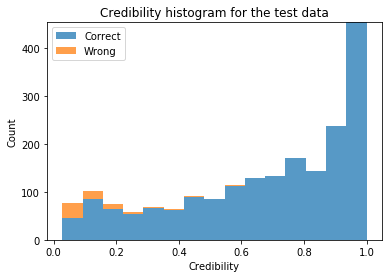

In [18]:
test_hist_results=np.empty([15,3])
hist_correct=test_data_credibility[test_data_correct==True,1]
hist_wrong=test_data_credibility[test_data_correct!=True,1]
n, bins, patches = plt.hist([hist_correct,hist_wrong], 15, stacked=True, alpha=0.75, label=["Correct", "Wrong"])
test_hist_results[:,0]=bins[:15]
test_hist_results[:,1]=n[0]
test_hist_results[:,2]=n[1]-n[0]
plt.xlabel('Credibility')
plt.ylabel('Count')
plt.title('Credibility histogram for the test data')
plt.legend()
plt.show()         

## Adversarial Inputs

Now we want to see how the algorithm behaves when we use adversarial data. To generate the adversarial data we use the Fast gradient sign method. 

Let's explain tis method briefly. We train a NN with repeated process of sampling data, calculating the gradient of the loss function with respect to the parameters of the NN and performing a parameter update to minimize the loss function (or increase the score assigned to the corect label). When the gradient with respect to a parameter is negative, this means that increasing this parameter will decrease the score assigned to the correct label. So this process works by having a fixed input and wiggling the model parameters to increase the score of whatever class we wanted. 

We can fool the NN by flipping this process. That is, we will hold the model parameters fixed, and instead we're computing the gradient of all pixels in the input image on any class we might desire. We compute the gradient of the loss function with respect to the input pixels with the end result being that we increase the score of whatever class we want.

In the following example we start with the image of the digit 1 and make the appropriate changes to the pixels so that it will be classified as 0. We see that the changes in the image of 1 are so small that we can't notice them but the input is still classified as 0 using the traditional softmax. However the proposed algorithm, even though it gives a wrong prediction it assigns a very low credibility, sign that ths prediction is not trustful. 

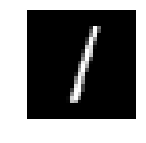

predictions [1]
Candidate labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


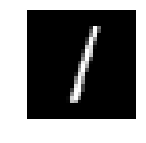

predictions [9]
Softmax probability 1 [0.]
Softmax probability 0 [4.996928e-33]
Candidate labels [0 0 0 7 0 0 5 0 5 7 7 0 2 8 0 7 0 0 7 9 0 0 9 0 7 7 7 0 0 0 8 5 5 7 5 0 7
 0 0 7 0 0 7 7 9 0 4 4 7 0 7 4 0 7 7 0 0 6 5 7 6 0 0 5 7 0 0 0 0 0 4 0 7 0
 0 5 9 9 9 5 9 5 9 5 8 9 9 5 9 8 7 0 8 9 9 9 9 5 7 5 5 9 9 9 0 5 5 7 9 5 5
 9 3 9 7 5 9 0 9 7 7 9 9 5 7 7 8 7 8 9 7 9 0 9 9 0 9 0 4 9 0 9 5 9 0 9 5 8
 9 7 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 8 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5
 5 5 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 8 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5
 5 5 5 5]
Candidate label 0 appears 44 times. It has non comformity 256 , p_value 0.011875
Candidate label 2 appears 1 times. It has non comformity 299 , p_value 0.000125
Candidate label 3 appears 1 times. It has non comformity 299 , p_value 0.000125
Candidate label 4 appears 5 times. It has non comfor

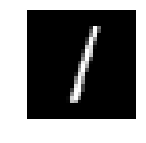

predictions [0]
Softmax probability 1 [0.]
Softmax probability 0 [1.]
Candidate labels [0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 6 0 0 8 0 6 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Candidate label 0 appears 288 times. It has non comformity 12 , p_value 0.678625
Candidate label 2 appears 4 times. It has non comformity 296 , p_value 0.000875
Candidate label 5 appears 1 times. It has non comformity 299 , p_value 0.000125
Candidate label 6 appears 6 times. It has non comformity 294 ,

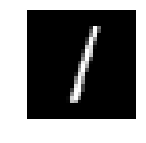

predictions [0]
Softmax probability 1 [0.]
Softmax probability 0 [1.]
Candidate labels [0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 6 0 0 8 0 6 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Candidate label 0 appears 288 times. It has non comformity 12 , p_value 0.678625
Candidate label 2 appears 4 times. It has non comformity 296 , p_value 0.000875
Candidate label 5 appears 1 times. It has non comformity 299 , p_value 0.000125
Candidate label 6 appears 6 times. It has non comformity 294 ,

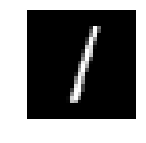

predictions [0]
Softmax probability 1 [0.]
Softmax probability 0 [1.]
Candidate labels [0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 6 0 0 8 0 6 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Candidate label 0 appears 288 times. It has non comformity 12 , p_value 0.678625
Candidate label 2 appears 4 times. It has non comformity 296 , p_value 0.000875
Candidate label 5 appears 1 times. It has non comformity 299 , p_value 0.000125
Candidate label 6 appears 6 times. It has non comformity 294 ,

In [19]:
original_images=test_set_x[2] #number 1
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(test_set_x[2].reshape([28, 28]),cmap = "gray")
plt.show()

target_number = 0
target_label = np.zeros(10)
target_label[target_number]=1

step_size = 3 #The amount to wiggle towards the gradient of target class.
steps = 4
adversarial_img = original_images.copy()
print("predictions", sess.run(tf.argmax(y,1),feed_dict={x: adversarial_img.reshape(1, 784)}))
hd1,hd2,hd3=sess.run([y1,y2,y3], feed_dict={x: adversarial_img.reshape(1, 784)})
input_hash_calibration,l1_hash_calibration,l2_hash_calibration,l3_hash_calibration=LSH(adversarial_img.reshape(1, 784),hd1,hd2,hd3,planes1,planes2,planes3,planes4)
dist, indices_input_calibration = input_nbrs.kneighbors(input_hash_calibration)
dist, indices_l1_calibration = l1_nbrs.kneighbors(l1_hash_calibration)
dist, indices_l2_calibration = l2_nbrs.kneighbors(l2_hash_calibration)
dist, indices_l3_calibration = l3_nbrs.kneighbors(l3_hash_calibration)
indices_labels_input_test=train_labels[indices_input_calibration]
indices_labels_l1_test=train_labels[indices_l1_calibration]
indices_labels_l2_test=train_labels[indices_l2_calibration]
indices_labels_l3_test=train_labels[indices_l3_calibration]
candidate_labels=np.concatenate((np.concatenate((np.concatenate((indices_labels_input_test,indices_labels_l1_test),axis=1),indices_labels_l2_test),axis=1),indices_labels_l2_test),axis=1)
print('Candidate labels', candidate_labels[0])

#Targeted attack using Fast gradient sign method inspired from http://blog.ycombinator.com/how-adversarial-attacks-work/
# and http://karpathy.github.io/2015/03/30/breaking-convnets/
for i in range(0, steps):
    gradient = sess.run(img_gradient,feed_dict={x: adversarial_img.reshape(1, 784), y_: target_label.reshape(1, 10)})
    #Update using value of gradient
    adversarial_img = adversarial_img - step_size * gradient
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(test_set_x[2].reshape([28, 28]),cmap = "gray")
    plt.show()
    print("predictions", sess.run(tf.argmax(y,1),feed_dict={x: adversarial_img}))
    probabilities_val = sess.run(tf.nn.softmax(y),feed_dict={x: adversarial_img})
    print('Softmax probability 1', probabilities_val[:, 1])
    print('Softmax probability',target_number, probabilities_val[:, target_number])
    
    hd1,hd2,hd3=sess.run([y1,y2,y3], feed_dict={x: adversarial_img.reshape(1, 784)})
    input_hash_calibration,l1_hash_calibration,l2_hash_calibration,l3_hash_calibration=LSH(adversarial_img.reshape(1, 784),hd1,hd2,hd3,planes1,planes2,planes3,planes4)
    dist, indices_input_calibration = input_nbrs.kneighbors(input_hash_calibration)
    dist, indices_l1_calibration = l1_nbrs.kneighbors(l1_hash_calibration)
    dist, indices_l2_calibration = l2_nbrs.kneighbors(l2_hash_calibration)
    dist, indices_l3_calibration = l3_nbrs.kneighbors(l3_hash_calibration)
    indices_labels_input_test=train_labels[indices_input_calibration]
    indices_labels_l1_test=train_labels[indices_l1_calibration]
    indices_labels_l2_test=train_labels[indices_l2_calibration]
    indices_labels_l3_test=train_labels[indices_l3_calibration]
    candidate_labels=np.concatenate((np.concatenate((np.concatenate((indices_labels_input_test,indices_labels_l1_test),axis=1),indices_labels_l2_test),axis=1),indices_labels_l2_test),axis=1)
    print('Candidate labels', candidate_labels[0])
    cla,unc=np.unique(candidate_labels[0],return_counts=True)
    c=0
    
    max_temp=0
    second_max=0
    for j in np.unique(candidate_labels):
        non_comformity_temp=np.count_nonzero(candidate_labels != j)
        p_value=np.count_nonzero(calibration_noncomformity>=non_comformity_temp)/len(calibration_noncomformity)
        print("Candidate label",j,"appears",unc[c],"times. It has non comformity",non_comformity_temp,", p_value",p_value)
        c+=1
        if p_value>max_temp:
            max_temp=p_value
            predicted_label=j
        elif p_value>second_max:
            second_max=p_value
    print('Predicted label is', predicted_label)
    print('Confidence:', 1-second_max)
    print('Credibility:', p_value)
    


To test this method in different adversarial inputs I'll use all the test data as original inputs and for each input I'll change the pixels so that the predicted label will be the original label increased by 1.

Adversarial input generation:

In [20]:
steps=300
step_size=2
counter=0

adversarial_inputs=np.empty([np.size(test_labels)-calibration_size,784])
adversarial_true_label=np.empty([np.size(test_labels)-calibration_size,10])
for i in range(10):
    o_label=i
    t_label=(i+1)%10
    index_mask = np.where(test_labels_oh[calibration_size:, o_label])[0] #find all the data with label o_label
    original_images = test_set_x[calibration_size+index_mask]
    original_labels = test_labels_oh[calibration_size+index_mask]
    target_labels = np.zeros(original_labels.shape)
    target_labels[:, t_label] = 1
    adversarial_img = original_images.copy()
    for kk in range(steps):
        gradient = img_gradient.eval({x: adversarial_img, y_: target_labels})
        adversarial_img = adversarial_img - step_size * gradient
    adversarial_inputs[counter:counter+np.size(index_mask)]=adversarial_img
    adversarial_true_label[counter:counter+np.size(index_mask)]=original_labels
    counter+=np.size(index_mask)

We find the nearest neighbors for each layer of every adversarial input

In [21]:
hd1,hd2,hd3=sess.run([y1,y2,y3], feed_dict={x: adversarial_inputs})
input_hash_adversarial,l1_hash_adversarial,l2_hash_adversarial,l3_hash_adversarial=LSH(adversarial_inputs,hd1,hd2,hd3,planes1,planes2,planes3,planes4)
indices_input_adversarial = input_nbrs.kneighbors(input_hash_adversarial,return_distance=False)
indices_l1_adversarial = l1_nbrs.kneighbors(l1_hash_adversarial,return_distance=False)
indices_l2_adversarial = l2_nbrs.kneighbors(l2_hash_adversarial,return_distance=False)
indices_l3_adversarial = l3_nbrs.kneighbors(l3_hash_adversarial,return_distance=False)
indices_labels_input_test=train_labels[indices_input_adversarial]
indices_labels_l1_test=train_labels[indices_l1_adversarial]
indices_labels_l2_test=train_labels[indices_l2_adversarial]
indices_labels_l3_test=train_labels[indices_l3_adversarial]

Now we need to predict the label for each of the adversarial data and produce he confidence and credibility metrics

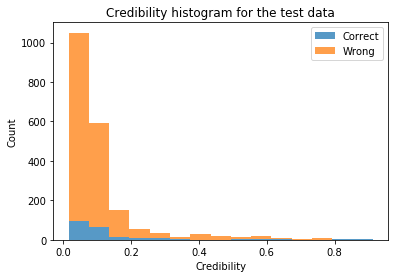

In [22]:
candidate_labels=np.concatenate((np.concatenate((np.concatenate((indices_labels_input_test,indices_labels_l1_test),axis=1),indices_labels_l2_test),axis=1),indices_labels_l2_test),axis=1)
adversarial_data_credibility=np.empty([adversarial_inputs.shape[0],2])
adversarial_data_predictions_knn=np.empty(adversarial_inputs.shape[0])

for i in range(adversarial_inputs.shape[0]):
    cla,unc=np.unique(candidate_labels[i],return_counts=True)
    c=0

    max_temp=0
    second_max=0
    #print(adversarial_true_label[i])
    #print(cla)
    for j in np.unique(cla):
        non_comformity_temp=np.count_nonzero(candidate_labels[i] != j)
        p_value=np.count_nonzero(calibration_noncomformity>=non_comformity_temp)/len(calibration_noncomformity)
        #print("Candidate label",j,"appears",unc[c],"times. It has non comformity",non_comformity_temp,", p_value",p_value)
        c+=1
        if p_value>max_temp:
            max_temp=p_value
            predicted_label=j
        elif p_value>second_max:
            second_max=p_value
    #print('Predicted label is', predicted_label)
    #print('Confidence:', 1-second_max)
    #print('Credibility:', p_value)
    adversarial_data_credibility[i,0]=1-second_max
    adversarial_data_credibility[i,1]=max_temp
    adversarial_data_predictions_knn[i]=max_ind
adversarial_data_correct=test_data_predictions_knn==np.argmax(adversarial_true_label,1)
    
adv_hist_results=np.empty([15,3])
hist_correct=adversarial_data_credibility[adversarial_data_correct==True,1]
hist_wrong=adversarial_data_credibility[adversarial_data_correct!=True,1]
n, bins, patches = plt.hist([hist_correct,hist_wrong], 15, stacked=True, alpha=0.75, label=["Correct", "Wrong"])
adv_hist_results[:,0]=bins[:15]
adv_hist_results[:,1]=n[0]
adv_hist_results[:,2]=n[1]-n[0]
plt.xlabel('Credibility')
plt.ylabel('Count')
plt.title('Credibility histogram for the test data')
plt.legend()
plt.show()      


Based on the 2 histograms above we see that most of the missclassified test data, both genuine and adversarial have low credibility. A natural approach to increase the accuracy of the classifier would be to answer definitely only for the inputs with credibility above a chosen threshold and generate an alarm for all the other inputs for further investigation. We face a tradeoff between accuracy and unclassified data. Chosing a credibility threshold high enouh will produce a very high accuracy but also a large number of alarms. We will lso be protected against adversarial inputs as they tend to produce low credibility. On the other hand lowering the threshold, we have to deal with less alarms but we may not detect some adversarial inputs.